# Scene recognition

In [19]:
import torch,json,os,importlib

# Select model from available
os.listdir("pretrained_models/")
model_path="pretrained_models/sub2/"
os.listdir(model_path)

# Load model


with open(model_path+'model_config.json',"r")as f:
    model_config=json.load(f)


module = importlib.import_module('models.{}'.format(model_config['arch']))
Network = getattr(module, 'Network')
model=Network(model_config)


state_dict=torch.load(model_path+"/model_state_dict.pth")
# if the weights are float16 cast the model
if [v for k,v in state_dict.items()][0].dtype==torch.float16:
    model=model.half()
    print("model in float16")
model.load_state_dict(state_dict)

# print(model)

n_blocks_per_stage is specified ignoring the depth param, nc=None



Warning Pruning only 1x1 CONVS

108 0.05892556509887896 0.0936585811581694
109 0.05892556509887896 0.0936585811581694
110 0.05892556509887896 0.0936585811581694
111 0.1767766952966369 0.0936585811581694
112 0.125 0.0936585811581694
113 0.125 0.0936585811581694
model in float16


<All keys matched successfully>

# PyRoomAudio dev

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pyroomacoustics as pra
import torch
from pyroomacoustics.doa import circ_dist
import IPython

In [35]:
# Create the array
R = pra.linear_2D_array([2, 1.5], 4, 0, 0.1)
print(R)

kinect_R = np.array([[0.0, 0.04, 0.02, -0.02, -0.04, -0.02, 0.02],
            [0.0, 0.0, -0.03464, -0.03464, 0.0, 0.03464, 0.03464]])
kinect_R [0,:] +=25.0
kinect_R [1,:] +=20.0
print(kinect_R)

philbart_R = np.array([[0.0, 0.0, 0.0, -0.5, -0.5, -0.5, 0.5, 0.5, 0.5],
            [-0.5, 0.0, 0.5, -0.5, 0.0, 0.5, -0.5, 0.0, 0.5]])
philbart_R [0,:] +=25.0
philbart_R [1,:] +=20.0
print(philbart_R)

[[1.85 1.95 2.05 2.15]
 [1.5  1.5  1.5  1.5 ]]
[[25.      25.04    25.02    24.98    24.96    24.98    25.02   ]
 [20.      20.      19.96536 19.96536 20.      20.03464 20.03464]]
[[25.  25.  25.  24.5 24.5 24.5 25.5 25.5 25.5]
 [19.5 20.  20.5 19.5 20.  20.5 19.5 20.  20.5]]


## Beamforming calcs

<Figure size 640x480 with 0 Axes>

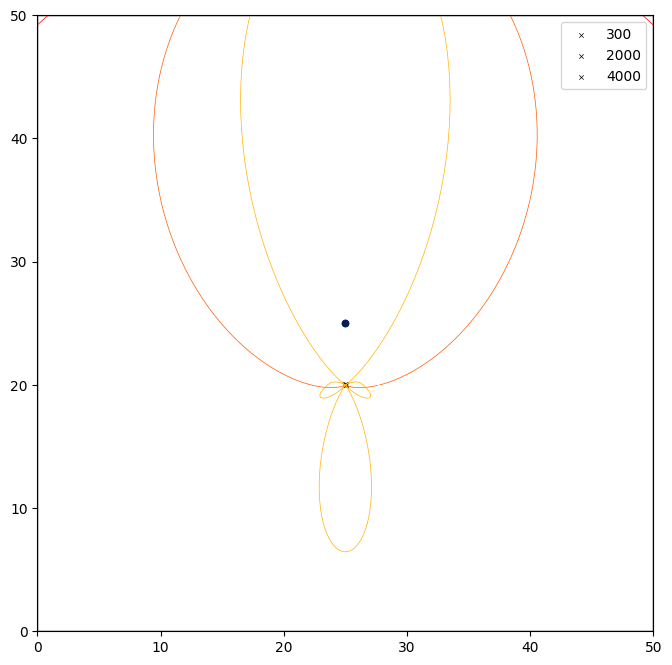

<Figure size 640x480 with 0 Axes>

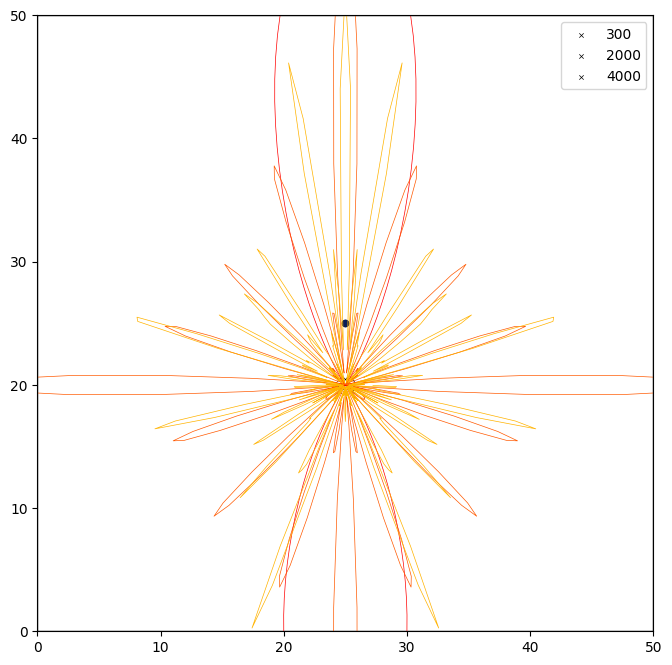

In [39]:
Lg_t = 0.100                # filter size in seconds
Lg = np.ceil(Lg_t*fs)       # in samples
fs=48000
c=343.0
nfft=256

# Create "Room"
kinect_room_bf = pra.ShoeBox([50,50], fs=fs, max_order=12)
philbart_room_bf = pra.ShoeBox([50,50], fs=fs, max_order=12)
source = np.array([25, 25])
kinect_room_bf.add_source(source, delay=0.)
philbart_room_bf.add_source(source, delay=0.)

# Create kinect and philbart mic arrays
kinect_mics = pra.Beamformer(kinect_R, room_bf.fs, N=nfft, Lg=Lg)
philbart_mics = pra.Beamformer(philbart_R, room_bf.fs, N=nfft, Lg=Lg)
kinect_room_bf.add_microphone_array(kinect_mics)
philbart_room_bf.add_microphone_array(philbart_mics)

# Compute beamformer weights
kinect_mics.rake_delay_and_sum_weights(kinect_room_bf.sources[0][:1])
philbart_mics.rake_delay_and_sum_weights(philbart_room_bf.sources[0][:1])

plt.figure()
fig, ax = kinect_room_bf.plot(freq=[300, 2000, 4000], img_order=0)
ax.legend(['300', '2000','4000'])
fig.set_size_inches(20, 8)

plt.figure()
fig, ax = philbart_room_bf.plot(freq=[300, 2000,4000], img_order=0)
ax.legend(['300', '2000','4000'])
fig.set_size_inches(20, 8)



In [ ]:


# Analyze Kinect beam pattern




In [7]:
# Load signal data from mike array
signals = torch.load('../../frame_data_recovered.pt')
print(signals.T.shape)

# compute STFT
nfft=256
fs=48000
c=343.0
freq_bins = np.arange(15, 300)  # FFT bins to use for estimation
Lg_t = 0.100                # filter size in seconds
Lg = np.ceil(Lg_t*fs)       # in samples


mics = pra.Beamformer(kinect_R, fs, N=nfft, Lg=Lg)

torch.Size([6, 16000])


In [8]:
sources = {'twelve_o_clock': {'az': 0.},
# 'eleven_o_clock': {'az': 30.},
# 'ten_o_clock': {'az': 60.},
'nine_o_clock': {'az': 90.},
# 'eight_o_clock': {'az': 120.},
# 'seven_o_clock': {'az': 150.},
'six_o_clock': {'az': 180.},
# 'five_o_clock': {'az': 210.},
# 'four_o_clock': {'az': 240.},
'three_o_clock': {'az': 270.}} #,
# 'two_o_clock': {'az': 300.},
# 'one_o_clock': {'az': 330.}}

mics.record(signals.T,fs)

for src in sources.keys():
    exec(src+ "_bf = mics")
    exec(src+ "_bf.far_field_weights(" + str(sources[src]['az']) + "*np.pi/180)")

# laptop_src = pra.soundsource.SoundSource(position=[-.5,-1])
# front_src = pra.soundsource.SoundSource(position=[.1,0])
plt.figure()
for bf in sources.keys():
    bf += "_bf"
    print("plt.plot(" + bf + ".process()")
    exec("plt.plot(" + bf + ".process())")
    


# mics.far_field_weights(240*np.pi/180)
# mics.rake_delay_and_sum_weights(laptop_src)



# proc = mics.process()
# mics.plot()

# # IPython.display.Audio(data=signals.T[0,:],rate=fs)
# IPython.display.Audio(data=proc, rate=fs)

NameError: The signals array should have as many lines as there are microphones.

In [9]:
proc.shape

NameError: name 'proc' is not defined

## DOA calcs

In [100]:
# Load signal data from mike array
signals = torch.load('../../frame_data_recovered.pt')
print(signals.T.shape)

# compute STFT
nfft=256
fs=48000
c=343.0
freq_bins = np.arange(15, 300)  # FFT bins to use for estimation
X = np.array(
    [
        pra.transform.stft.analysis(signal, nfft, nfft // 2).T
        for signal in signals.T
    ]
)
print(X.shape)

torch.Size([7, 48000])
(7, 129, 375)


FRIDA


/home/jd/anaconda3/envs/gracias/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


FRIDA
  Recovered azimuth: [351.72459364] degrees
  Error: [21.72459364] degrees


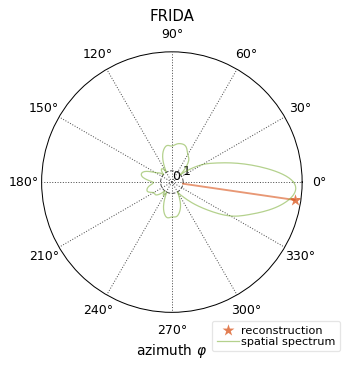

In [107]:
##############################################
# Now we can test all the algorithms available
algo_names = sorted(pra.doa.algorithms.keys())
algo_names = ['FRIDA']
azimuth=330*np.pi/180

for algo_name in algo_names:
    print(algo_name)
    # Construct the new DOA object
    # the max_four parameter is necessary for FRIDA only
    doa = pra.doa.algorithms[algo_name](kinect_R, fs, nfft, c=c, max_four=4)

    # this call here perform localization on the frames in X
    doa.locate_sources(X, freq_bins=freq_bins)

    doa.polar_plt_dirac()
    plt.title(algo_name)

    # doa.azimuth_recon contains the reconstructed location of the source
    print(algo_name)
    print("  Recovered azimuth:", doa.azimuth_recon / np.pi * 180.0, "degrees")
    print("  Error:", circ_dist(azimuth, doa.azimuth_recon) / np.pi * 180.0, "degrees")

plt.show()

# Grid/heatmap

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

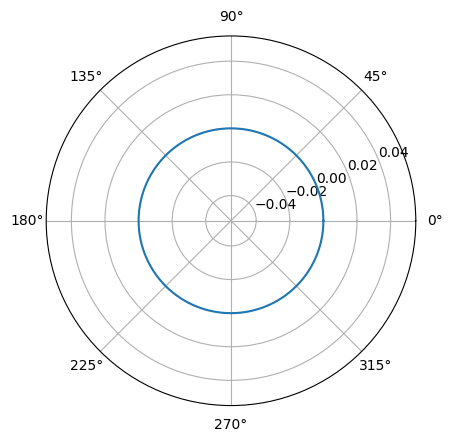

In [111]:

# doa.grid.set_values(0.0)
doa._process(X)
doa.grid.plot()

print(doa.grid.values)

# Torch audio dev

In [6]:
import torch
import torchaudio
import numpy as np

In [7]:
n_channels = 7
src = 'plughw:2,0'
sample_rate = 48000
hop_size = 4800
frame_size = 4800
fmt = 'alsa'
options = {"sample_rate": str(sample_rate), "channels": str(n_channels)}

streamer = torchaudio.io.StreamReader(src=src, format=fmt, option={'sample_rate':'48000','channels':'7'})
streamer.add_basic_audio_stream(frames_per_chunk=hop_size, sample_rate=sample_rate, num_channels=n_channels)

print(str(streamer.get_src_stream_info(0)))

SourceAudioStream(media_type='audio', codec='pcm_s16le', codec_long_name='PCM signed 16-bit little-endian', format='s16', bit_rate=5376000, num_frames=0, bits_per_sample=0, metadata={}, sample_rate=48000.0, num_channels=7)


In [8]:
def beam_projection(pos, az):
    pos_angle = np.arctan2(pos[1],pos[0])
    # make sure pos_angle in range [0, 2pi)

    while pos_angle < 0:
        pos_angle += 2*np.pi
    while pos_angle > 2*np.pi:
        pos_angle -= 2*np.pi

    while pos_angle < 0:
        pos_angle += 2*np.pi
    while pos_angle > 2*np.pi:
        pos_angle -= 2*np.pi
    
    print("mike_angle: %s" % pos_angle)
    print("az: %s" % az)
    delta_angle = az - pos_angle
    print("delta: %s" % delta_angle)
    return np.sqrt(pos[0]**2 + pos[1]**2)*np.cos(delta_angle)

In [9]:
pos = [np.sqrt(3),1]
az = np.deg2rad(30)

beam_projection(pos,az)

mike_angle: 0.5235987755982989
az: 0.5235987755982988
delta: -1.1102230246251565e-16


1.9999999999999998

# Examine beams

In [10]:
import torch
import matplotlib.pyplot as plt

orig_channels = torch.load('../../frame_data_original.pt')
rec_channels = torch.load('../../frame_data_recovered.pt')
beams = torch.load('../../beam_data.pt')

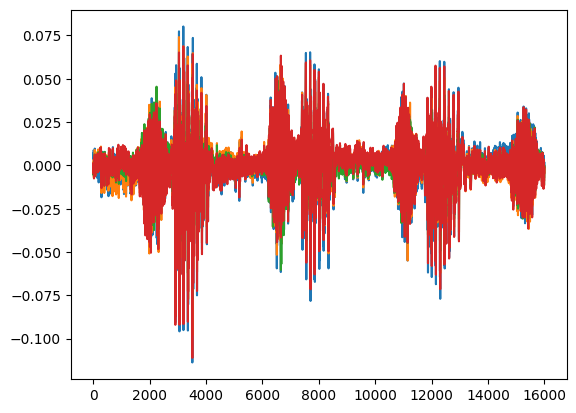

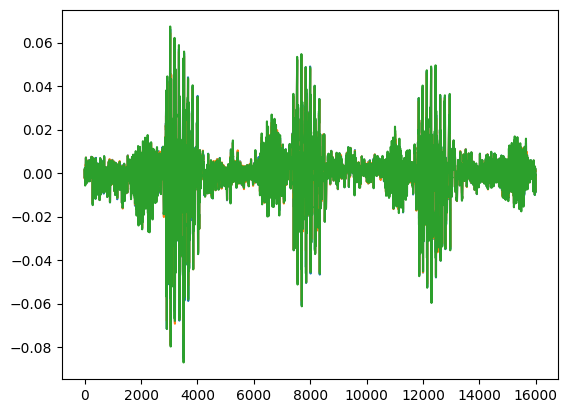

In [13]:
# plt.plot(beam[:,2])
plt.figure(1)
for channel in [1,2,3,4]:
    # print(channel)
    plt.plot(rec_channels[:,channel])
# plt.plot(rec_channels[:,0])

plt.figure(2)
for beam in range(beams.shape[1]):
    plt.plot(beams[:,beam])

In [25]:
# parameter i/o
import json


param_dict = {0: {'pos': [0., 0., 0.]},
                             1: {'pos': [.04, 0., 0.]},
                             2: {'pos': [.02, -.034641016, 0.]}, 
                             3: {'pos': [-.02, -.034641016, 0.]},
                             4: {'pos': [-.04, 0., 0.]},
                             5: {'pos': [-.02, .034641016, 0.]}, 
                             6: {'pos': [.02, .034641016, 0.]}}

In [26]:

json.dump(param_dict, 'params.json')

AttributeError: 'str' object has no attribute 'write'